#  Computational Illustration for Chapter 14
# Sparse Recovery from Linear Observations

In [1]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
from scipy.optimize import linprog
import warnings
warnings.filterwarnings('ignore')

## Illustration of the success of L1-minimization

In [2]:
## generate a sparse vector and the corresponding observation vector
# select problem sizes
N = 800
m = 200
s = 40
# create the sparse vector x to be recovered
x = np.zeros(N)
aux = np.random.permutation(N)
supp = aux[:s]
supp.sort()
x[supp] = np.random.normal(0,1,s)
# produce the observation vector y
A = np.sqrt(np.pi/2/m)*np.random.normal(0,1,size=(m,N))
y = A@x

The $\ell_1$-minimization program is solved in two different ways:
fisrt, by solving the linear program
$$
\underset{z,c\in\mathbb{R}^N}{\rm minimize} \sum_{j=1}^N c_j  \qquad \mbox{subject to } Az = y, \; -c \leq z \leq c;
$$
second, by solving the linear program
$$
\underset{z^+,z^-\in\mathbb{R}^N}{\rm minimize} \sum_{j=1}^N (z^+_j + z^-_j)
\qquad \mbox{subject to } A(z^+-z^-) = y, \; z^+ \ge 0, \; z^- \ge 0.
$$

In [3]:
# For the first linear program:
# define the objective (the variable is the 2N-dim vector [z;c])
obj_1 = np.append(np.zeros(N), np.ones(N), axis=0)
# define the equality constraint
lhs_eq = np.append(A, np.zeros((m,N)), axis=1)
rhs_eq = y
# define the inequality constraint
I = np.identity(N)
lhs_ineq = np.append( np.append(-I, -I, axis=1), np.append(I, -I, axis=1), axis=0 )
rhs_ineq = np.zeros(2*N)
# perform the optimization
opt1 = linprog(c=obj_1, A_ub=lhs_ineq, b_ub=rhs_ineq, A_eq=lhs_eq, b_eq=rhs_eq, bounds=(None,None), method="interior-point")
x1 = opt1.x[:N]
rel_error1 = LA.norm(x-x1)/LA.norm(x)
print("Recovery considered to be {},".format("exact" if rel_error1<1e-5 else "inexact"))
print("with a relative L2-error of {}.".format(rel_error1))

Recovery considered to be exact,
with a relative L2-error of 3.28955901375788e-09.


In [4]:
# For the second linear program:
# define the objective (the variable is the 2N-dim vector [z^+;z^-])
obj_2 = np.ones(2*N)
# define the equality constraint
lhs_eq = np.append(A, -A, axis=1)
rhs_eq = y
# set the bounds
bnd = [(0, np.inf) for _ in range(2*N)]
# perform the optimization
opt2 = linprog(c=obj_2, A_eq=lhs_eq, b_eq=rhs_eq, bounds=bnd, method="interior-point")
# the solution is z = z^+ - z^-
x2 = opt2.x[:N]-opt2.x[N:]
rel_error2 = LA.norm(x-x2)/LA.norm(x)
print("Recovery considered to be {},".format("exact" if rel_error2<1e-5 else "inexact"))
print("with a relative L2-error of {}.".format(rel_error2))

Recovery considered to be exact,
with a relative L2-error of 4.438473753613236e-12.


## Explore the influence of the number of measurements

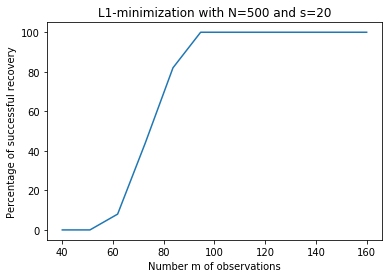

In [5]:
N = 500
s = 20
m_min = 2*s
m_max = 8*s
m_inc = 10
n_tests = 50
res = np.zeros( (n_tests,int((m_max-m_min)/m_inc)) )
for m in range(m_min,m_max,m_inc):
    for t in range(n_tests):
        xx = np.zeros(N)
        aux = np.random.permutation(N)
        supp = aux[:s]
        supp.sort()
        xx[supp] = np.random.rand(s)
        A = np.random.rand(m,N)
        y = A@xx
        obj = np.ones(2*N)
        lhs_eq = np.append(A, -A, axis=1)
        rhs_eq = y
        bnd = [(0, np.inf) for _ in range(2*N)]
        opt = linprog(c=obj, A_eq=lhs_eq, b_eq=rhs_eq, bounds=bnd, method="interior-point")
        xstar = opt.x[:N]-opt.x[N:]
        res[t,int((m-m_min)/m_inc)] = ( LA.norm(xx-xstar) < 1e-5*LA.norm(xx) )
plt.plot(np.linspace(m_min,m_max,int((m_max-m_min)/m_inc)),100*np.mean(res,axis=0))
plt.xlabel('Number m of observations')
plt.ylabel('Percentage of successful recovery')
plt.title('L1-minimization with N=' +str(N) +' and s=' +str(s))
plt.show()